<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Centro_Universitario_del_Guadalajara_Logo.png/640px-Centro_Universitario_del_Guadalajara_Logo.png" alt="Drawing" style="width: 600px;"/>
</center>
    
<center> <span style="color:DarkBlue">  Tema 13: Redes neuronales, Regresión lineal </span>  </center>
<center> <span style="color:Blue"> M. en C. Iván A. Toledano Juárez </span>  </center>

# Regresión lineal con redes neuronales

La **regresión lineal simple** es uno de los modelos fundamentales en aprendizaje automático supervisado. Su objetivo es encontrar una relación lineal entre una **variable independiente** $x$ y una **variable dependiente** $y$, es decir, ajustar una recta a un conjunto de datos:

\begin{equation}
\hat{y} = w \cdot x + b
\end{equation}

Donde:

- $\hat{y}$: valor predicho por el modelo
- $x$: valor de entrada (feature)
- $w$: peso (pendiente) que define la inclinación de la recta
- $b$: sesgo (intersección con el eje $y$)

Aunque esta tarea puede resolverse fácilmente con álgebra lineal o librerías como scikit-learn, construir una regresión lineal como una **red neuronal simple** en PyTorch nos permite:

- Aprender cómo se estructuran los modelos en PyTorch (`nn.Module`)
- Comprender el flujo de entrenamiento: forward, loss, backward, optimizer
- Aplicar las mismas herramientas que se usan en redes neuronales profundas (como `autograd` y `optim`)
- Visualizar cómo los parámetros del modelo se ajustan con cada época

Una red neuronal con:

- **una sola neurona**
- **activación lineal (sin no linealidades)**
- y **una sola entrada**

es equivalente a un modelo de regresión lineal simple.

---

En este notebook implementaremos este modelo paso a paso, entrenándolo sobre un conjunto de datos sintético. Veremos cómo el modelo aprende a aproximar la relación lineal entre $x$ y $y$ usando descenso de gradiente y optimización basada en pérdida.


In [1]:
# Importación de librerías

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display

# pytorch
import torch
print('Version de PyTorch =',torch.__version__)
from torch import nn # bloques fundamentales de nn de pytorch

Version de PyTorch = 2.8.0


### Importación de datos

In [2]:
df = pd.read_csv("../data/mtcars/mtcars.csv")
df['disp_0_46'] = df['disp']**(-0.46) # agregamos una variable transformada 
df.head(5)

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,disp_0_46
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,0.096851
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4,0.096851
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,0.116045
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1,0.077742
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2,0.066696


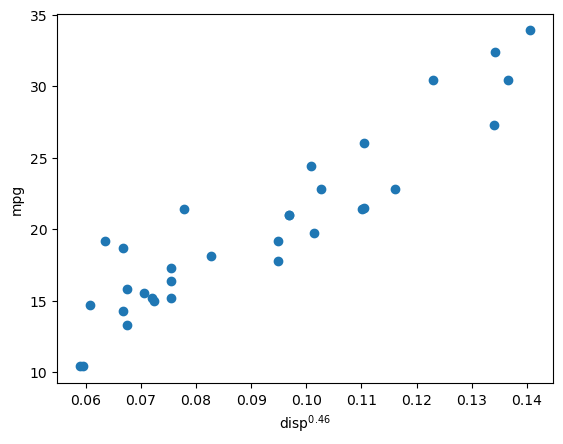

In [3]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.scatter(df['disp_0_46'], df['mpg'])

ax.set_xlabel(r'disp$^{0.46}$')
ax.set_ylabel('mpg')

plt.show()

### Preparación de datos

In [4]:
# pasamos a arrays y luego a tensores
mpg_array = df['mpg'].to_numpy()
disp_array_046 = df['disp_0_46'].to_numpy()
total_array = np.concatenate((mpg_array,disp_array_046))

In [5]:
X = torch.from_numpy(disp_array_046)
y = torch.from_numpy(mpg_array)

In [6]:
# Create *known* parameters
#weight = 0.7
#bias = 0.3

# Create data
#start = 0
#end = 1
#step = 0.02
#X = torch.arange(start, end, step).unsqueeze(dim=1)
#y = weight * X + bias

#X[:10], y[:10]


In [6]:
## Crear set de entrenamiento y validación

train_split = int(0.8 * len(X)) # 80% de los datos para entrenamiento
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(25, 25, 7, 7)

In [7]:
# Se crea una función para visualizar los datos

def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Se grafican los datos de entrenamiento, validación y se comparan predicciones
  """
  plt.figure(figsize=(8, 5))

  # Datos de entrenamiento (azul)
  plt.scatter(train_data, train_labels, c="b", s=12, label="Datos de entrenamiento")
  
  # Datos de prueba (verde)
  plt.scatter(test_data, test_labels, c="g", s=12, label="Datos de test")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=12, label="Predictions")

  # Labels
  plt.legend(prop={"size": 14});


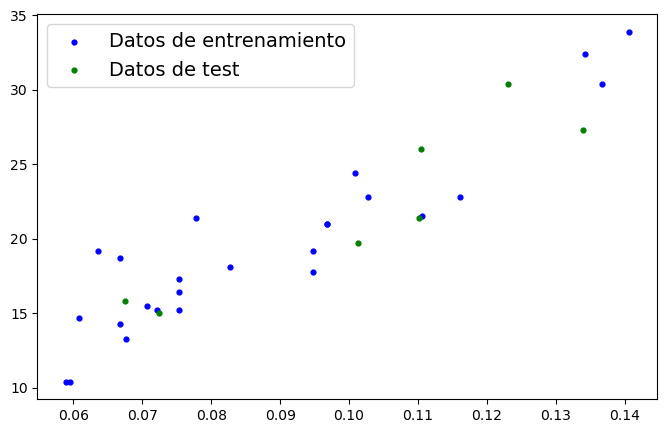

In [8]:
plot_predictions()

## Construcción de un modelo de regresión lineal con PyTorch

En esta sección construiremos nuestro propio modelo de **regresión lineal simple** utilizando PyTorch. Lo haremos mediante la creación de una clase que hereda de `nn.Module`, el bloque fundamental para definir modelos en PyTorch.

Recordemos que en la **regresión lineal**, el objetivo es aprender una relación de la forma:

\begin{equation}
\hat{y} = w \cdot x + b
\end{equation}

donde:

- $x$ es la variable independiente (input),
- $w$ es el peso o pendiente,
- $b$ es el sesgo o término independiente (bias),
- $\hat{y}$ es la predicción generada por el modelo.

---

### ¿Qué incluye la clase?

- **`__init__()`**: define los parámetros entrenables del modelo (en este caso, `weights` y `bias`), ambos inicializados aleatoriamente mediante `torch.randn()` y envueltos en `nn.Parameter`, lo que le indica a PyTorch que deben ser optimizados durante el entrenamiento.

- **`forward()`**: define cómo se calcula la salida del modelo a partir de una entrada `x`. En este caso, implementamos la fórmula de regresión lineal simple: $y = w \cdot x + b$.

---

### Consideraciones 

- **Herencia de `nn.Module`**: permite que el modelo integre automáticamente mecanismos de PyTorch como el tracking de gradientes, `state_dict()`, y uso de `.to(device)`.

- **`requires_grad=True`**: permite que estos parámetros participen en el cálculo de gradientes durante el backpropagation.

- Este diseño es muy flexible: en versiones más complejas se pueden añadir más capas, transformaciones no lineales, etc.

A continuación, implementamos esta clase:


In [18]:
class LinearRegressionModel(nn.Module): # <- La entrada es un objeto nn.Module de PyTorch
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # se comienzan con pesos aleatorios (que luego serán actualizados)
                                                dtype=torch.float), # el dtype es float32 por default
                                   requires_grad=True) # True, para poder actualizar estos pesos con gradiente descendiente

        self.bias = nn.Parameter(torch.randn(1, # se comienza con un bias aleatorio (que luego será actualizado)
                                            dtype=torch.float),
                                requires_grad=True) 

    # Forward define la forma de calcular en el modelo
    def forward(self, x: torch.Tensor) -> torch.Tensor: # "x" son los datos de entrada
        return self.weights * x + self.bias # formula de regresión lineal

## Fundamentos del módulo `torch.nn` en PyTorch

El submódulo `torch.nn` es el núcleo de PyTorch para construir redes neuronales. Proporciona las herramientas necesarias para definir modelos de manera modular, incluyendo capas, funciones de activación, pérdidas y utilidades de entrenamiento.

---

### `torch.nn.Module`

Es la **clase base de todos los modelos en PyTorch**. Al heredar de `nn.Module`, una clase personalizada puede:

- Registrar automáticamente sus parámetros entrenables.
- Integrarse con funcionalidades como `.parameters()`, `.state_dict()`, `.eval()`, `.to(device)`, etc.
- Ser compatible con el sistema de gradientes de PyTorch (`autograd`).

> Toda subclase de `nn.Module` debe implementar el método `forward()`.

---

### `torch.nn.Parameter`

Es una subclase especial de `torch.Tensor` que indica a PyTorch que el tensor es **un parámetro entrenable del modelo**.

Cuando se asigna un `nn.Parameter` como atributo de un `nn.Module`, este será incluido automáticamente en `.parameters()` y participará en el cálculo de gradientes (si `requires_grad=True`).

---

###  `def forward(self, x)`

Este método debe ser implementado en toda subclase de `nn.Module` y define **cómo se calcula la salida a partir de la entrada**. Es la lógica de cómputo del modelo.

Cuando se llama al modelo como función (`output = model(x)`), internamente se ejecuta el método `forward()`.

---

### `torch.nn`

Es el submódulo general que contiene:

- Clases para construir modelos (`nn.Module`, `nn.Sequential`)
- Capas (`nn.Linear`, `nn.Conv2d`, etc.)
- Funciones de activación (`nn.ReLU`, `nn.Sigmoid`, etc.)
- Funciones de pérdida (`nn.MSELoss`, `nn.CrossEntropyLoss`, etc.)

---

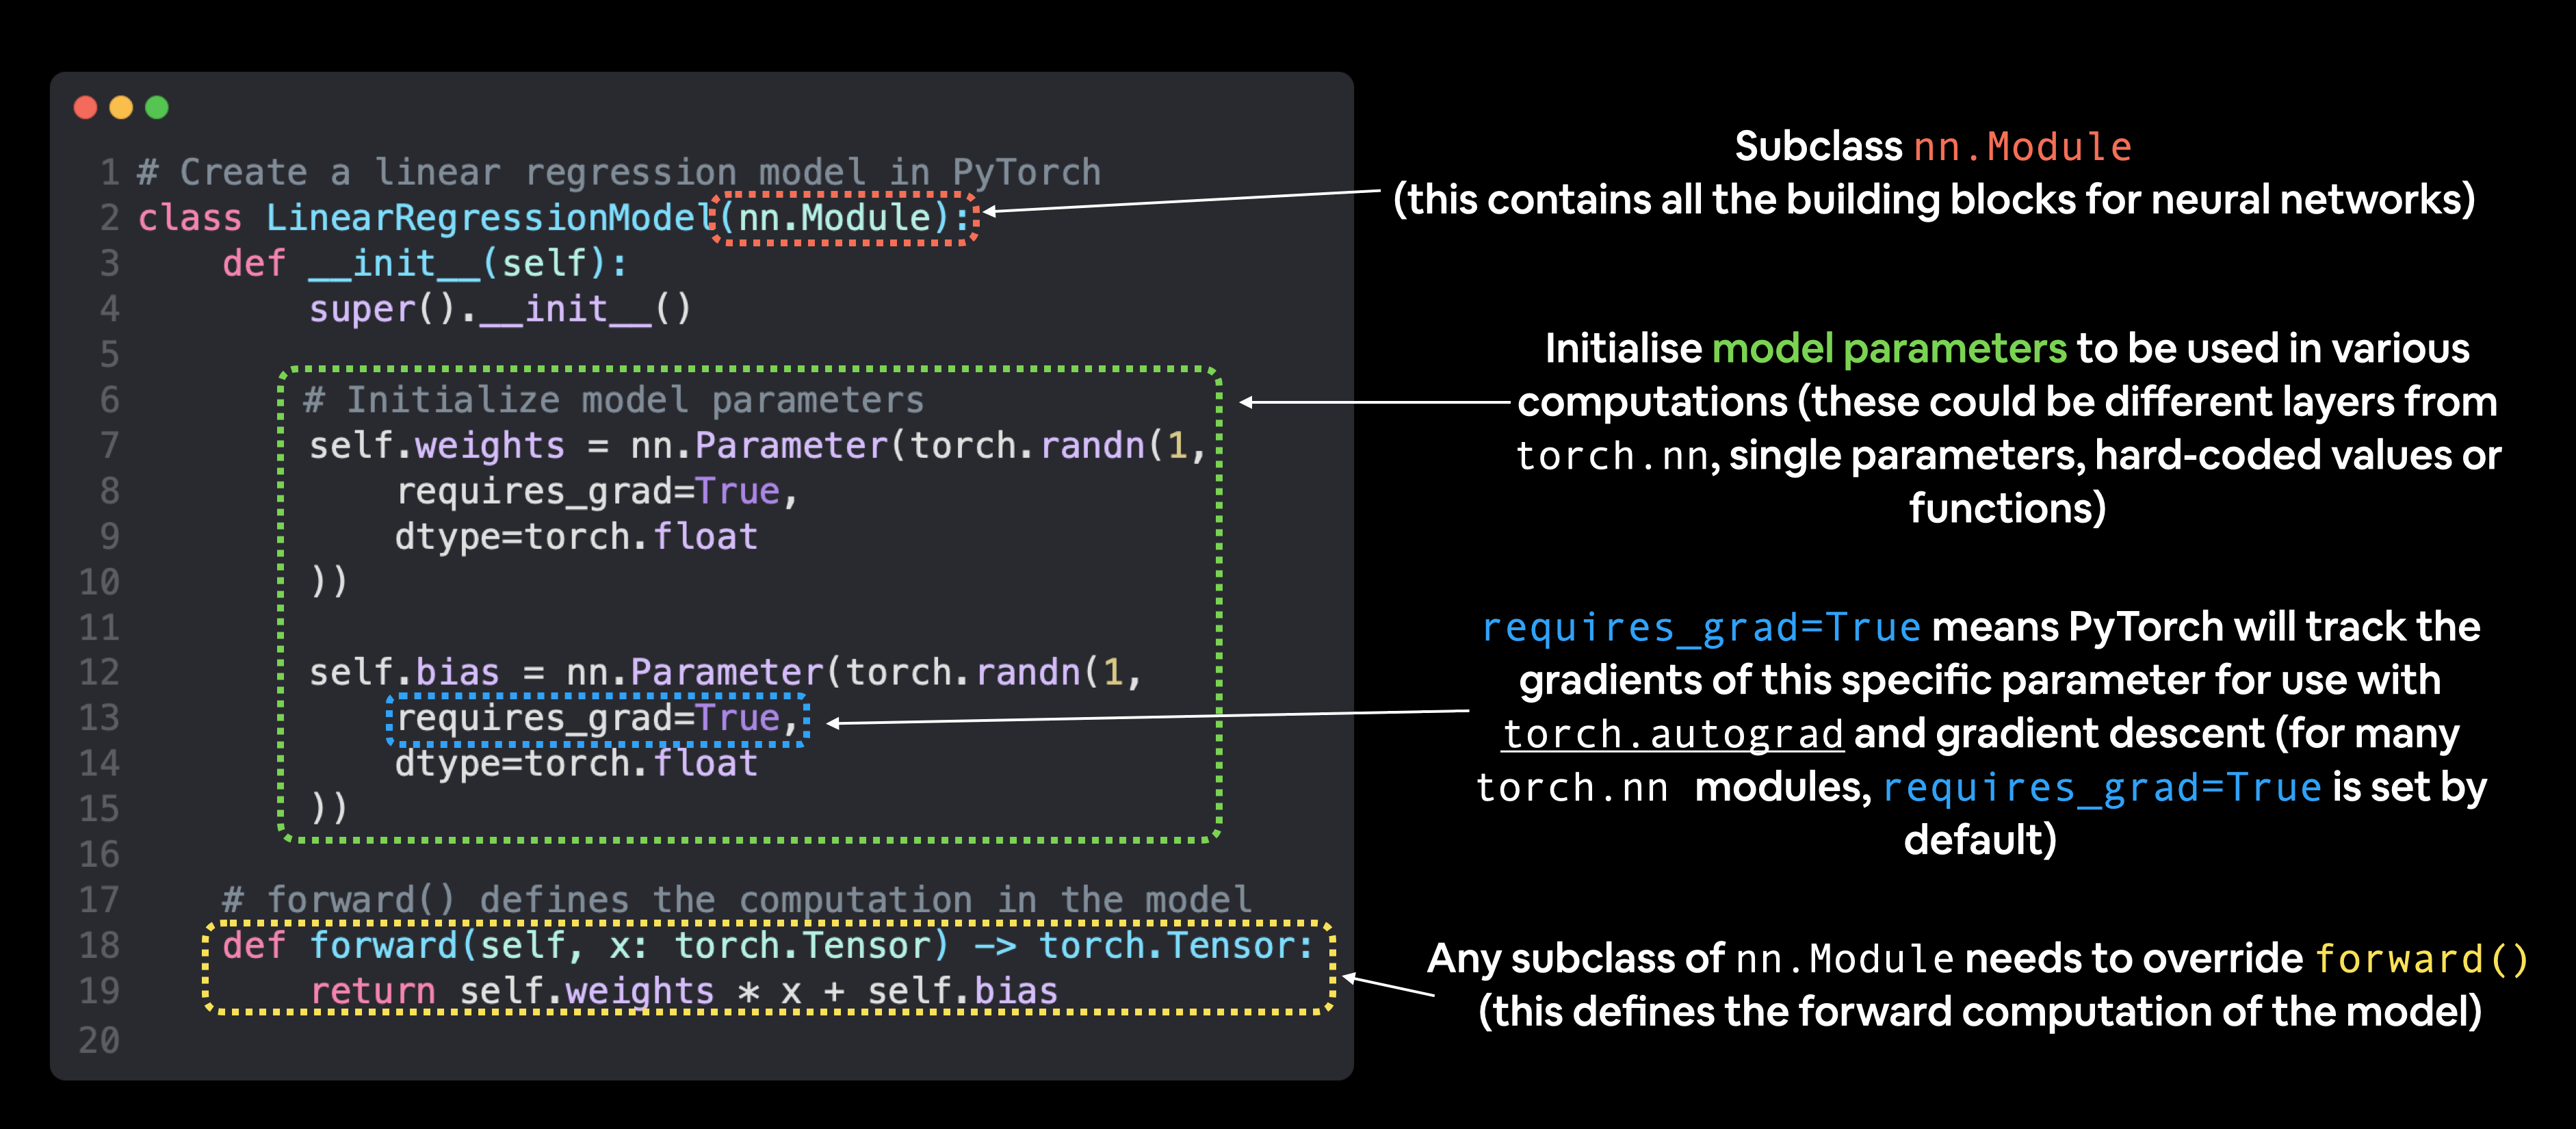

In [10]:
display(Image("imagenes/pytorch_class.png"))

In [19]:
# Semilla aleatoria
torch.manual_seed(88)

# Creamos una primer instancia del modelo
model_0 = LinearRegressionModel()
#model_0 = model_0.to("mps")

# Checamos los parámetros nn.Parameter(s) dentro de la subclase nn.Module que se creo
print(list(model_0.parameters()))

weight = model_0.state_dict()['weights'].clone()
bias = model_0.state_dict()['bias'].clone()
print(model_0.state_dict())

[Parameter containing:
tensor([0.5734], requires_grad=True), Parameter containing:
tensor([1.3148], requires_grad=True)]
OrderedDict([('weights', tensor([0.5734])), ('bias', tensor([1.3148]))])


Los tensores para los pesos y bias de entrada fueron generados aleatoriamente con randint.

In [20]:
# Predicciones
# Ponemos como input el X_test para ver como predice el y_test
# Estos datos pasarán por el método forward definido anteriormente forward() y se produce un resultado utilizando el cálculo que nosotros dijimos.

with torch.inference_mode(): # Se utiliza este método para hacer inferencias (no entrenamiento)
    y_preds = model_0(X_test)

# Checamos las predicciones
print(f"Número de muestra (test): {len(X_test)}") 
print(f"Número de predicciones: {len(y_preds)}")
print(f"Valores predichos:\n{y_preds}")


Número de muestra (test): 7
Número de predicciones: 7
Valores predichos:
tensor([1.3917, 1.3781, 1.3854, 1.3535, 1.3729, 1.3564, 1.3780],
       dtype=torch.float64)


No todas las inferencias tienen que ser un mapeo 1 a 1. En algunos casos podría ser que 100 valores X se encuentren mapeados a 1, 3 a 10, etc.

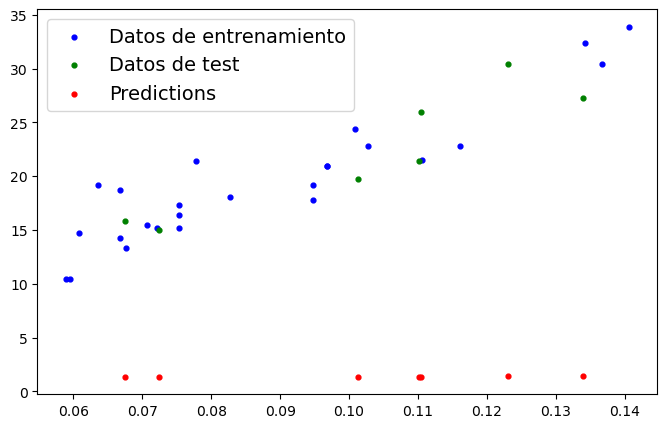

In [21]:
# Hacemos un plot de las predicciones
plot_predictions(predictions=y_preds)

Vemos que estas predicciones son malísimas. Esto es de esperar pues empezamos con unos pesos totalmente aleatorios, que tienen que ser ajustados.

In [22]:
# Checamos las desviaciones por valor
y_test - y_preds

tensor([25.9083, 24.6219, 29.0146, 14.4465, 18.3271, 13.6436, 20.0220],
       dtype=torch.float64)

## Entrenamiento del modelo

Se crea una **loss function** a optimizar, además de un **optimizer**, que le dice al modelo como actualizar sus parámetros internos para mejor dicha función de pérdida. Valores típicos podrían ser,

* **Loss function** ``torch.nn.L1Loss()``(MAE)
* **Optimizer** ``torch.optim.SGD()``(Stochastic gradient descent), ``torch.optim.Adam()``, etc.

En particular, utilizando ``torch.optim.SGD(params,lr)``, se tienen los siguientes parámetros.

* **params**, son los parámetros target del modelo que se buscan optimizar (en este caso serían los pesos y bias que fueron aleatorios).
* **lr**, es la taza de aprendizaje (**learning rate**) para el optimizador. Valores típicos pueden ser 0.01, 0.001, 0.0001, aunque pueden ser ajustados posteriormente.

In [24]:
# Se crea la función de pérdida
##loss_fn = nn.L1Loss() # equivalente a Mean Absolute Error (MAE)
loss_fn = nn.MSELoss() # equivalente e Mean Squared Error (MSE)

# Se crea el optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parámetros a optimizar
                            lr=0.03) # taza de aprendizaje

Posteriormente, lo que se tiene que hacer es crear un loop de optimización. Esto significa que el modelo va a ir revisando los datos de entrenamiento y "aprendiendo" las relaciones entre los **features** y **labels**

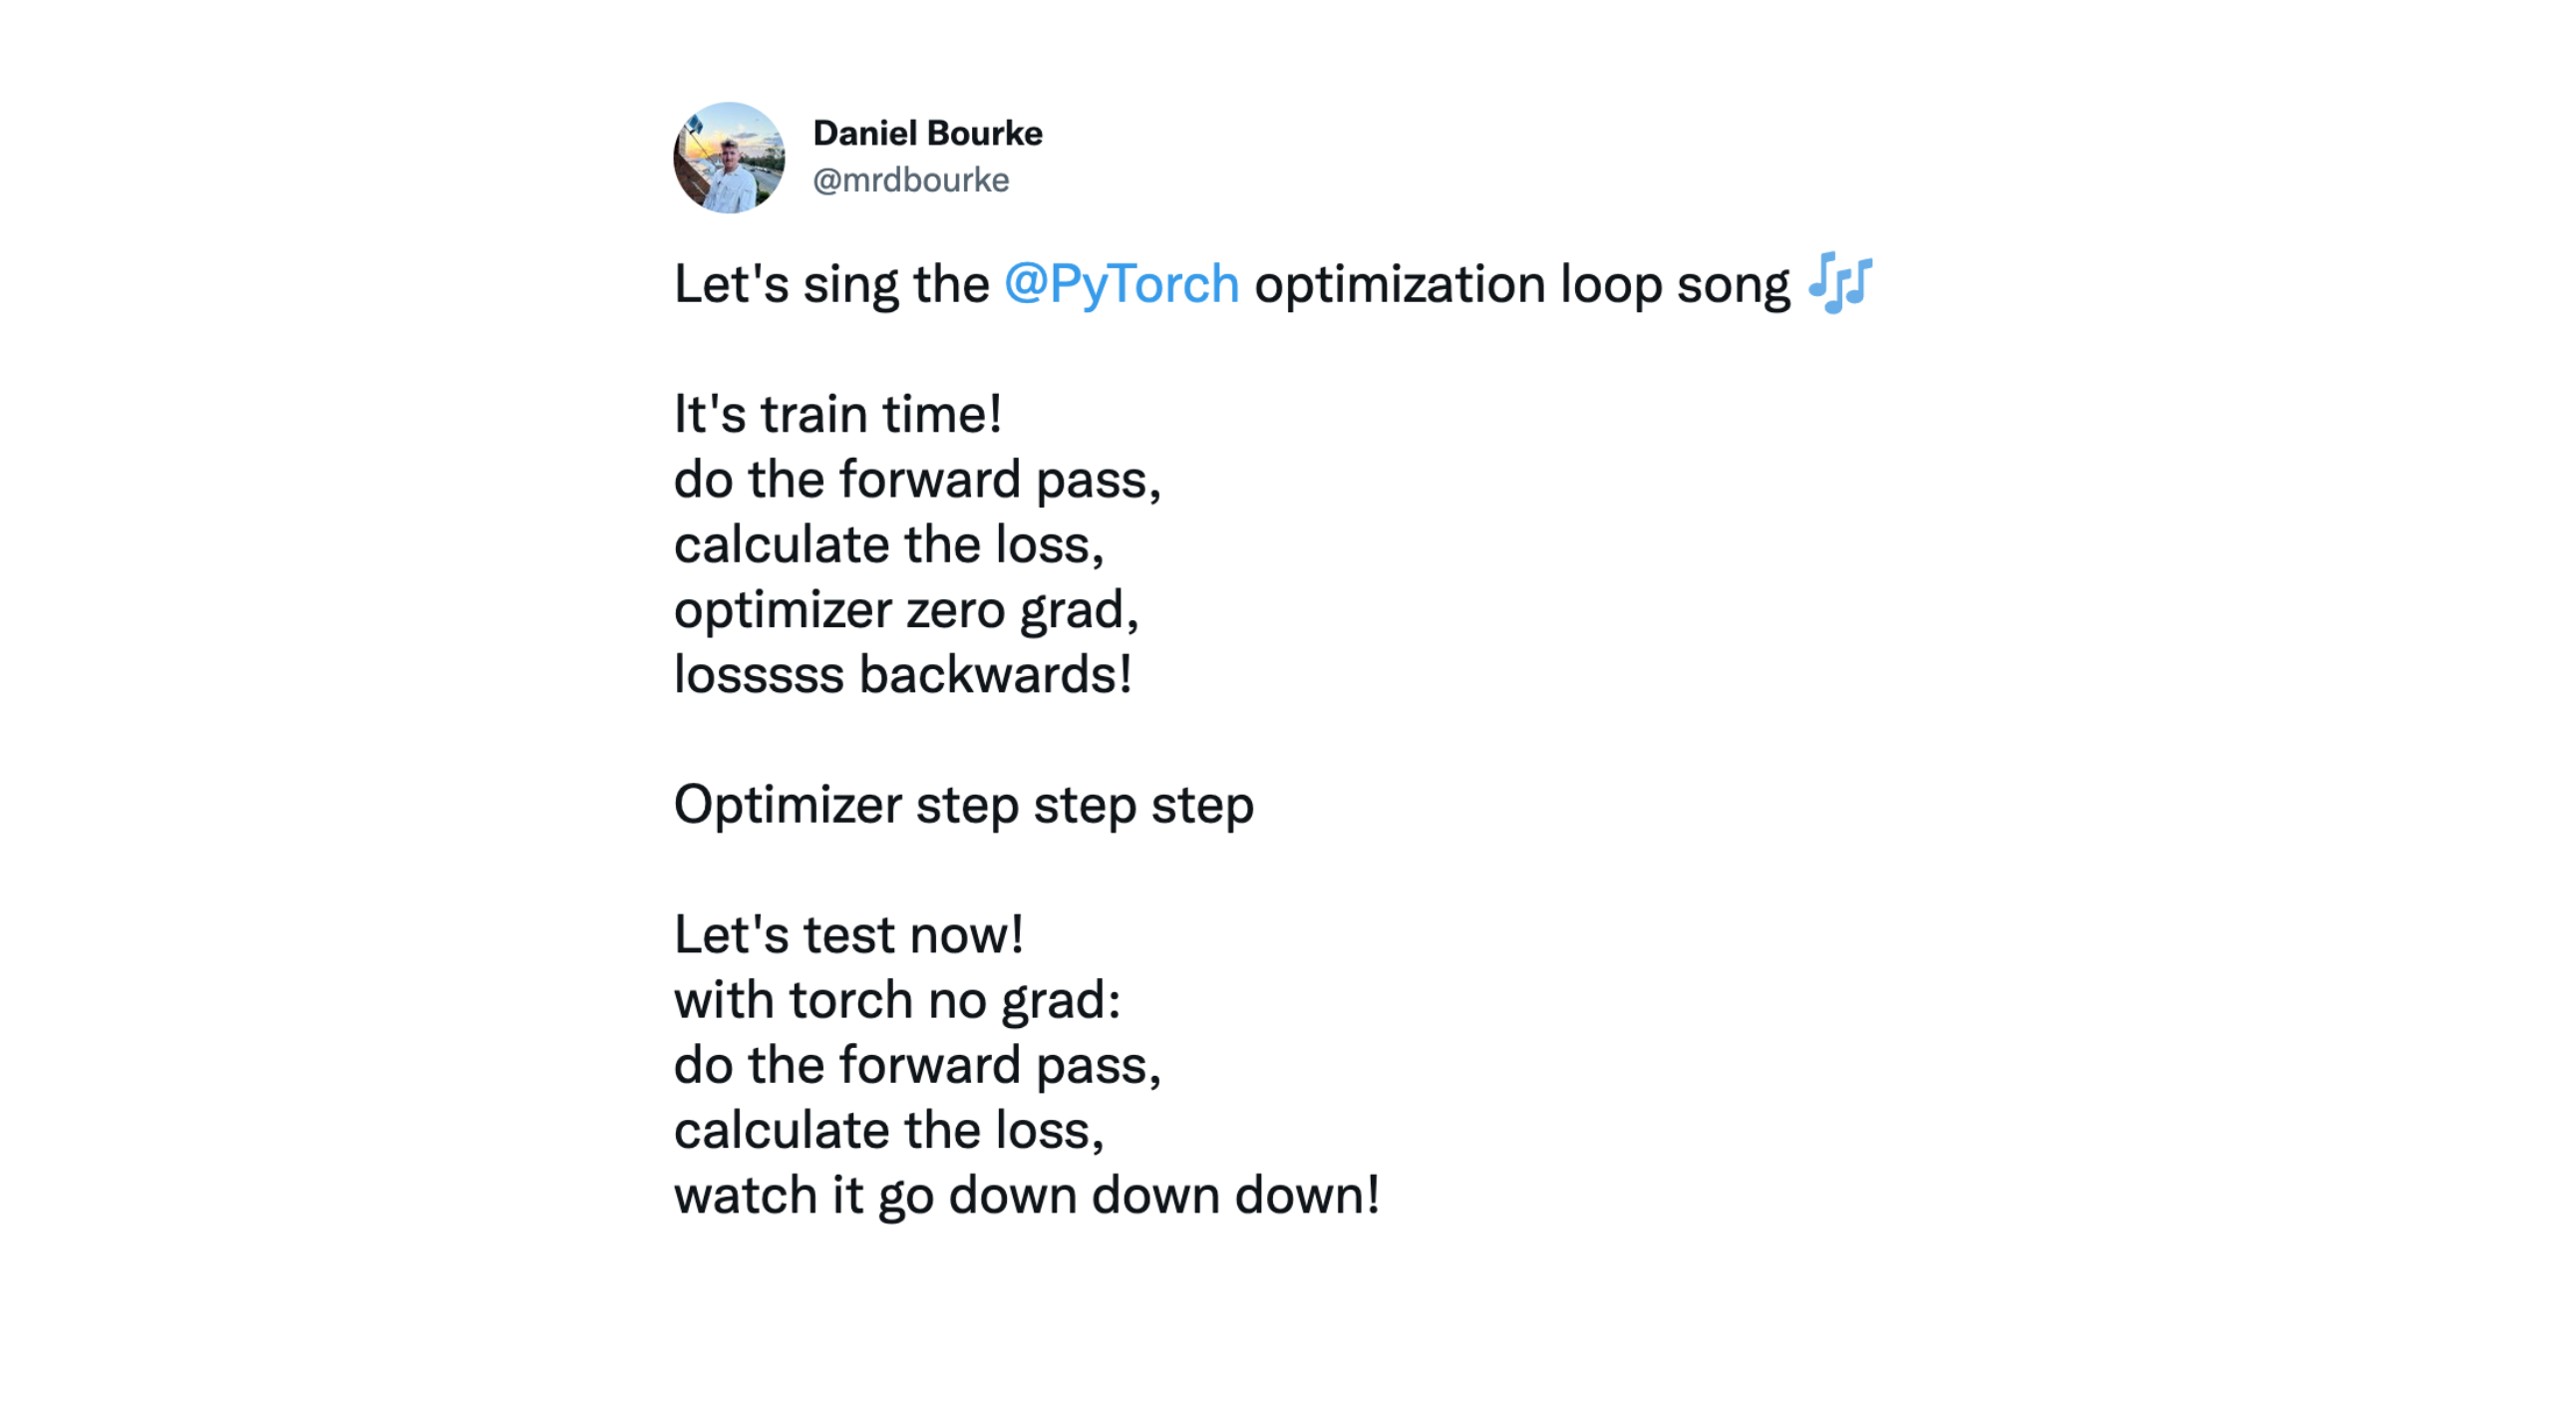

In [25]:
display(Image("imagenes/pytorch_song.png"))
#https://www.youtube.com/watch?v=Nutpusq_AFw
##

In [40]:
# Training Loop

# Número de época a entrenar (que tantas pasadas el modelo da sobre los datos de entrenamiento y se actualizan los pesos).
epochs = 50000

# Valores a comparar después
train_loss_values = []
test_loss_values = []
epoch_count = []

# Comienza Training Loop (con un número de épocas)
for epoch in range(epochs):

    # Poner el modelo en modo de entrenamiento (por default está así)
    model_0.train()

    # 1. Propagación hacia adelante
    y_pred = model_0(X_train)

    # 2. Calcular Loss Function
    loss = loss_fn(y_pred,y_train)

    # 3. Zero grad para el optimizador (se empieza en cero y se acumula en cada época)
    optimizer.zero_grad()

    # 4. Propagación hacia atrás (Backpropagation)
    loss.backward()

    # Progreso del optimizador
    optimizer.step()

    # Loop de testing

    # Poner el modelo en modo evaluation
    model_0.eval()

    with torch.inference_mode():

        # 1. Propagación hacia adelant
        test_pred = model_0(X_test)

        # 2. Se calcula la pérdida en los datos de test
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

        # Prints
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MSE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MSE Train Loss: 5.942055884105935 | MAE Test Loss: 5.255983104023456 
Epoch: 10 | MSE Train Loss: 5.941589668845007 | MAE Test Loss: 5.2557003934369435 
Epoch: 20 | MSE Train Loss: 5.941123615727289 | MAE Test Loss: 5.255417931724805 
Epoch: 30 | MSE Train Loss: 5.94065773049942 | MAE Test Loss: 5.255135945551174 
Epoch: 40 | MSE Train Loss: 5.940192007409057 | MAE Test Loss: 5.254854164203226 
Epoch: 50 | MSE Train Loss: 5.9397264464562 | MAE Test Loss: 5.25457258768096 
Epoch: 60 | MSE Train Loss: 5.939261047640848 | MAE Test Loss: 5.254291215984379 
Epoch: 70 | MSE Train Loss: 5.938795810963006 | MAE Test Loss: 5.254010049113485 
Epoch: 80 | MSE Train Loss: 5.938330737244023 | MAE Test Loss: 5.253729087068277 
Epoch: 90 | MSE Train Loss: 5.937865824841181 | MAE Test Loss: 5.253448329848745 
Epoch: 100 | MSE Train Loss: 5.937401074575847 | MAE Test Loss: 5.2531677774549035 
Epoch: 110 | MSE Train Loss: 5.936936486448019 | MAE Test Loss: 5.252887475832405 
Epoch: 120 | MSE 

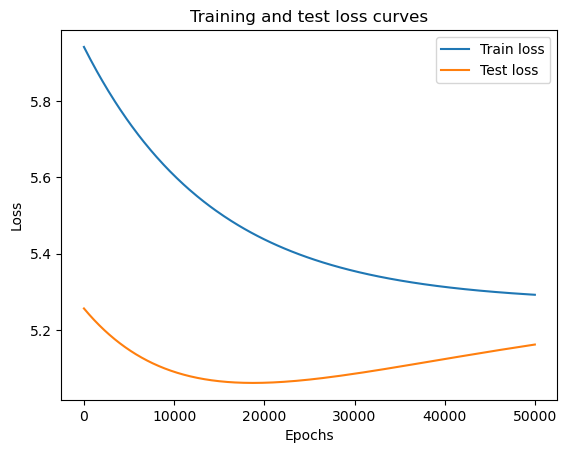

In [41]:
# Plot
# Curva de pérdida

plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();


**Loss curves** Tienen que bajar con respecto a las épocas, puesto que es una medida de que tan "mal/disperso" está el modelo.

In [42]:
# Imprimimos los parámetros actuales del modelo
print("El modelo tiene los siguientes valores para pesos y bias:")
print(model_0.state_dict())
print("\nLos valores originales fueron:")
print(f"weights: {weight}, bias: {bias}")

El modelo tiene los siguientes valores para pesos y bias:
OrderedDict([('weights', tensor([219.5225])), ('bias', tensor([0.1909]))])

Los valores originales fueron:
weights: tensor([0.5734]), bias: tensor([1.3148])


## Predicciones con el modelo entrenado de PyTorch

In [43]:
print(X_test)
print(17.9873 + (17.2355)*(0.1340))

tensor([0.1340, 0.1104, 0.1230, 0.0675, 0.1013, 0.0724, 0.1101],
       dtype=torch.float64)
20.296857000000003


In [44]:
# modo de prediccion
model_0.eval()

with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([29.6060, 24.4322, 27.2004, 15.0037, 22.4368, 16.0887, 24.3676],
       dtype=torch.float64)

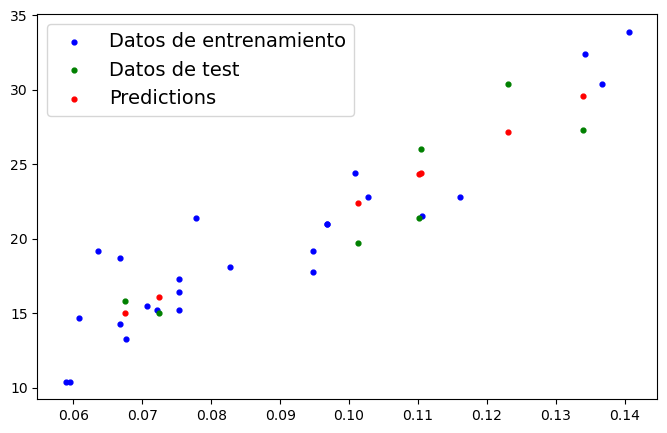

In [45]:
plot_predictions(predictions=y_preds)

In [117]:
y_preds

tensor([20.0708, 19.7803, 19.9357, 19.2509, 19.6683, 19.3118, 19.7767],
       dtype=torch.float64)

## Guardar/Cargar modelo de PyTorch

In [118]:
from pathlib import Path

# 1. Crear directorio de modelos (Si no existe)
MODEL_PATH = Path("PyTorchModels")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Path para guardar archivo
MODEL_NAME = "01_pytorch_workflow_model_0.pth" # por convención se utiliza extensión .pt o .pth
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Guardar modelo
print(f"Guardando en: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # Se guardan los parámetros aprendidos del modelo
           f=MODEL_SAVE_PATH) 

Guardando en: PyTorchModels/01_pytorch_workflow_model_0.pth


In [119]:
!ls -l PyTorchModels/01_pytorch_workflow_model_0.pth

-rw-r--r--@ 1 vanotole  staff  2117 Sep 22 16:09 PyTorchModels/01_pytorch_workflow_model_0.pth


In [120]:
# Cargar modelo

# Se inicializa un modelo nuevo (con parámetros aleatorios)
loaded_model_0 = LinearRegressionModel()

# Se carga el archivo state_dict del modelo guardado, que actualiza los parámetros que ya venían entrenados.
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [121]:
loaded_model_0.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

y_preds == loaded_model_preds


tensor([True, True, True, True, True, True, True])